In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras
import os

In [2]:
filenames = sorted(os.listdir('DIV2K_train_HR'))

block_size = 32
stride = 16

labels = []
for file in filenames:
    img = cv2.resize(cv2.imread('DIV2K_train_HR/'+file, 0),(1024,1024))
    row_num = (img.shape[0] - block_size) // stride + 1
    col_num = (img.shape[1] - block_size) // stride + 1

#     print(row_num)
#     print(col_num)

    data = []
    for y in range(row_num):
        for x in range(col_num):
            x_start = x*stride
            x_end = x_start+block_size
            y_start = y*stride
            y_end = y_start+block_size
            block = img[y_start:y_end, x_start:x_end]
            labels.append(block)

len(labels)

3175200

In [3]:
compressed_files = sorted(os.listdir('compressed_new'))

block_size = 32
stride = 16

compressed = []
for file in compressed_files:
    img = cv2.resize(cv2.imread('compressed_new/'+file, 0),(1024,1024))
    row_num = (img.shape[0] - block_size) // stride + 1
    col_num = (img.shape[1] - block_size) // stride + 1

#     print(row_num)
#     print(col_num)

    data = []
    for y in range(row_num):
        for x in range(col_num):
            x_start = x*stride
            x_end = x_start+block_size
            y_start = y*stride
            y_end = y_start+block_size
            block = img[y_start:y_end, x_start:x_end]
            compressed.append(block)

len(compressed)

3175200

In [4]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.0625, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(compressed[0:396900], labels[0:396900], test_size=0.2, random_state=42)

In [5]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


X_train = X_train.reshape(X_train.shape[0],32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

y_train = y_train.reshape(y_train.shape[0],32, 32, 1)
y_test = y_test.reshape(y_test.shape[0], 32, 32, 1)


X_train = X_train.astype('int')
X_test = X_test.astype('int')
y_train = y_train.astype('int')
y_test = y_test.astype('int')

# X_train /= 255
# X_test /= 255
# y_train /= 255
# y_test /= 255

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(317520, 32, 32, 1) (317520, 32, 32, 1) (79380, 32, 32, 1) (79380, 32, 32, 1)


In [6]:
# Defining the model
input_shape = (32,32,1)
model = keras.Sequential()
model.add(keras.layers.Conv2D(64, kernel_size=(9, 9), strides=(1, 1),activation='relu',input_shape=input_shape, use_bias = True, padding='same'))
model.add(keras.layers.Conv2D(32, (7, 7), strides=(1, 1),activation='relu', use_bias = True, padding='same'))
model.add(keras.layers.Conv2D(16, (1, 1), strides=(1, 1),activation='relu', use_bias = True, padding='same'))
model.add(keras.layers.Conv2D(1, (5, 5), use_bias = True, padding='same'))

In [7]:
# model.compile(optimizer=keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), 
#               loss='mean_squared_error')
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
filepath = 'ARCNN_weights_best.h5'
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=20, verbose=0, mode='min')

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=1, mode='min', min_lr=0.00001)

model_checkpt = keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min', period=1)

model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mean_absolute_error')


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        5248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        100384    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 16)        528       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 1)         401       
Total params: 106,561
Trainable params: 106,561
Non-trainable params: 0
_________________________________________________________________


In [9]:
results = model.fit(X_train, y_train, batch_size = 512, epochs = 100, shuffle=True, verbose = 1, validation_split = 0.2, callbacks = [reduce_lr, model_checkpt, early_stop])


Train on 254016 samples, validate on 63504 samples
Epoch 1/100
254016/254016 [==============================] - 27s 107us/step - loss: 7.8812 - val_loss: 5.7697
Epoch 2/100
254016/254016 [==============================] - 20s 79us/step - loss: 4.7256 - val_loss: 3.9116
Epoch 3/100
254016/254016 [==============================] - 20s 78us/step - loss: 3.9407 - val_loss: 3.8787
Epoch 4/100
254016/254016 [==============================] - 20s 78us/step - loss: 3.9305 - val_loss: 3.8998
Epoch 5/100
254016/254016 [==============================] - 20s 78us/step - loss: 3.8791 - val_loss: 3.6611
Epoch 6/100
254016/254016 [==============================] - 20s 79us/step - loss: 3.8308 - val_loss: 3.5984
Epoch 7/100
254016/254016 [==============================] - 20s 79us/step - loss: 3.8028 - val_loss: 3.7468
Epoch 8/100
254016/254016 [==============================] - 20s 79us/step - loss: 3.7813 - val_loss: 3.9071
Epoch 9/100
254016/254016 [==============================] - 20s 78us/step -

254016/254016 [==============================] - 20s 78us/step - loss: 3.3714 - val_loss: 3.3803
Epoch 75/100
254016/254016 [==============================] - 20s 78us/step - loss: 3.3709 - val_loss: 3.3792
Epoch 76/100
254016/254016 [==============================] - 20s 78us/step - loss: 3.3704 - val_loss: 3.3810
Epoch 77/100
254016/254016 [==============================] - 20s 79us/step - loss: 3.3679 - val_loss: 3.3773
Epoch 78/100
254016/254016 [==============================] - 20s 78us/step - loss: 3.3673 - val_loss: 3.3822
Epoch 79/100
254016/254016 [==============================] - 20s 78us/step - loss: 3.3663 - val_loss: 3.3762
Epoch 80/100
254016/254016 [==============================] - 20s 78us/step - loss: 3.3667 - val_loss: 3.3759
Epoch 81/100
254016/254016 [==============================] - 20s 78us/step - loss: 3.3651 - val_loss: 3.3728
Epoch 82/100
254016/254016 [==============================] - 20s 78us/step - loss: 3.3638 - val_loss: 3.3835
Epoch 83/100
254016/254

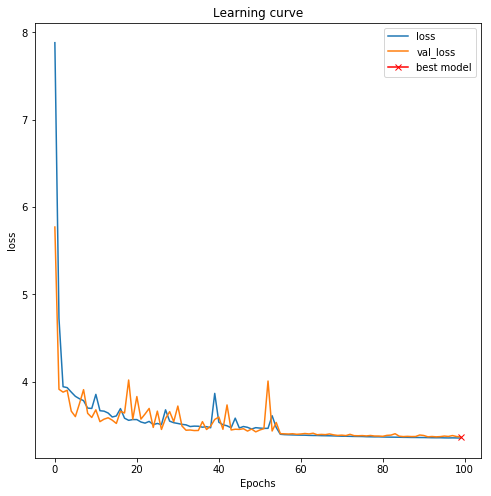

In [10]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

(32, 32)
MSE:  21.544921875
MSE:  26.4150390625


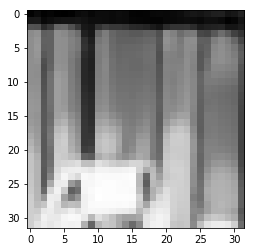

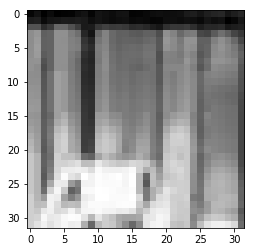

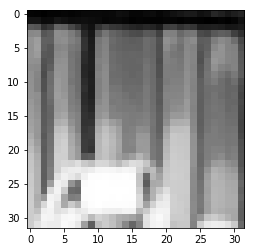

In [11]:
k = 10
test_img = X_test[k].reshape(1, 32, 32, 1)
pred_img = model.predict(test_img)
# print(pred_img)
pred_img = pred_img.reshape(32,32)
print(np.shape(pred_img))
plt.imshow(pred_img, cmap = 'gray')
plt.figure()
plt.imshow(X_test[k].reshape(32,32), cmap = 'gray')
plt.figure()
plt.imshow(y_test[k].reshape(32,32), cmap = 'gray')
err = np.sum((pred_img.astype("int") - y_test[k].reshape(32,32).astype("int")) ** 2)
err /= float(pred_img.shape[0] * pred_img.shape[1])
print("MSE: ",err)
err1 = np.sum((X_test[k].reshape(32,32).astype("int") - y_test[k].reshape(32,32).astype("int")) ** 2)
err1 /= float(pred_img.shape[0] * pred_img.shape[1])
print("MSE: ",err1)

In [12]:
# serialize model to JSON
model_json = model.to_json()
with open("ARCNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("ARCNN_model.h5")
print("Saved model to disk")

Saved model to disk


In [13]:
test_sample = cv2.resize(cv2.imread('compressed_new/'+compressed_files[5],0),(1024,1024))
# plt.imshow(test_sample)
row_num = (test_sample.shape[0] - block_size) // stride + 1
col_num = (test_sample.shape[1] - block_size) // stride + 1

print(row_num)
print(col_num)

test_data = [None]*row_num
for y in range(row_num):
    test = []
    for x in range(col_num):
        x_start = x*stride
        x_end = x_start+block_size
        y_start = y*stride
        y_end = y_start+block_size
        block = test_sample[y_start:y_end, x_start:x_end]
        test.append(model.predict(block.reshape(1,32,32,1)))
    test_data[y] = test
len(test_data)

63
63


63

In [14]:
print(row_num, col_num)
test_data = np.array(test_data)
# test_data.reshape(test_data.shape[0], 32, 32, 1)

63 63


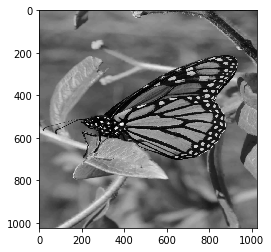

In [15]:
recon = np.ones((test_sample.shape[0],test_sample.shape[1],1))
test_data = np.array(test_data)
for i, row in enumerate(test_data):
    for j, col in enumerate(row):
        if i%2 == 0 and j%2 == 0:
            recon[(i*16):(i*16)+32, (j*16):(j*16)+32] = row[j]

for i, row in enumerate(test_data):
    for j, col in enumerate(row):
        if i%2 == 0 and j%2 == 0:
            recon[(i*16):(i*16)+32, (j*16):(j*16)+32] = (recon[(i*16):(i*16)+32, (j*16):(j*16)+32]
                                                                                        + row[j])/2

# for i, row in enumerate(test_data):
#     for j, col in enumerate(row):
#         recon[i*16:(i*16)+32, j*16:(j*16)+32] = row[j]

plt.imshow(recon.reshape(test_sample.shape[0],test_sample.shape[1]), cmap = 'gray') 

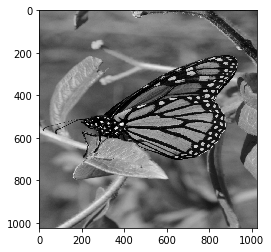

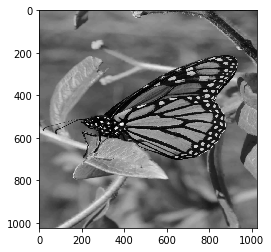

MSE:  11.511749267578125
MSE:  14.301674842834473


In [16]:
y = cv2.resize(cv2.imread('DIV2K_train_HR/'+filenames[5],0),(1024,1024))
recon.shape
x = cv2.resize(cv2.imread('compressed_new/'+compressed_files[5],0),(1024,1024))

# plt.subplot(121)
plt.imshow(y, cmap = 'gray')
plt.show()
# plt.subplot(122)
plt.imshow(recon[:,:,0], cmap = 'gray')
plt.show()

err = np.sum((recon.astype("int") - y.reshape(y.shape[0],y.shape[1],1).astype("int")) ** 2)
err /= float(recon.shape[0] * recon.shape[1])
print("MSE: ",err)
err1 = np.sum((x.astype("int") - y.reshape(y.shape[0],y.shape[1]).astype("int")) ** 2)
err1 /= float(recon.shape[0] * recon.shape[1])
print("MSE: ",err1)

In [17]:
import math
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

print(psnr(recon, y.reshape(y.shape[0],y.shape[1],1)))
print(psnr(x, y.reshape(y.shape[0],y.shape[1])))

37.7159026816582
37.30732820100431
